In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import MatlabRandn
from numpy.random import randn
from scipy.optimize import curve_fit
import scipy.stats as stats
import pylab 

In [2]:
randn = MatlabRandn()

In [3]:
def brownian_path(T, N):
    dt = T/N
    dW = np.sqrt(dt)*randn(N)
    dW = np.insert(dW, 0, 0)
    W = np.cumsum(dW)
    t = np.arange(0, T+dt, dt)
    return t, W

In [4]:
def solve_em(f, g, X_0, t, W):
    X_em = np.zeros(len(W))
    X_temp = X_0
    X_em[0] = X_0
    for j in range(1, len(W)):
        W_inc = W[j] - W[j-1]
        dt = t[j] - t[j-1]
        X_temp = X_temp + dt*f(X_temp) + g(X_temp)*W_inc
        X_em[j] = X_temp
    return t, X_em

In [5]:
def solve_milstein(f, g, g_deriv, X_0, t, W):
    X_em = np.zeros(len(W))
    X_temp = X_0
    X_em[0] = X_0
    for j in range(1, len(W)):
        W_inc = W[j] - W[j-1]

        dt = t[j] - t[j-1]
        X_temp = X_temp \
                 + dt*f(X_temp) \
                 + g(X_temp) * W_inc \
                 + 0.5 * g(X_temp) * g_deriv(X_temp) * (W_inc**2 - dt)
        X_em[j] = X_temp
    return t, X_em

In [6]:
def brownian_path2(T, N, M):
    dt = T/N
    dW = np.sqrt(dt)*randn(M, N)
    dW = np.hstack([np.zeros((M, 1)), dW])
    W = np.cumsum(dW, axis=1)
    t = np.arange(0, T+dt, dt)
    return t, W

In [7]:
def solve_em2(f, g, X_0, t, W):
    X_em = np.zeros(W.shape)
    X_0 = np.repeat(X_0, W.shape[0])
    X_temp = X_0
    X_em[:,0] = X_0
    for j in range(1, W.shape[1]):
        W_inc = W[:,j] - W[:,j-1]
        dt = t[j] - t[j-1]
        X_temp = X_temp + dt*f(X_temp) + g(X_temp)*W_inc
        X_em[:,j] = X_temp
    return t, X_em

In [8]:
def solve_milstein2(f, g, g_deriv, X_0, t, W):
    X_em = np.zeros(W.shape)
    X_0 = np.repeat(X_0, W.shape[0])
    X_temp = X_0
    X_em[:,0] = X_0
    for j in range(1, W.shape[1]):
        W_inc = W[:,j] - W[:,j-1]
        dt = t[j] - t[j-1]
        X_temp = X_temp \
                 + dt*f(X_temp) \
                 + g(X_temp) * W_inc \
                 + 0.5 * g(X_temp) * g_deriv(X_temp) * (W_inc**2 - dt)
        X_em[:,j] = X_temp
    return t, X_em

# bpath2.m

In [10]:
def reset_seed():
    try:
        randn.reset()
        print("Using Matlab Random Numbers")
    except AttributeError:
        np.random.seed(100)
        print("Using numpy Random Numbers")

Using Matlab Random Numbers


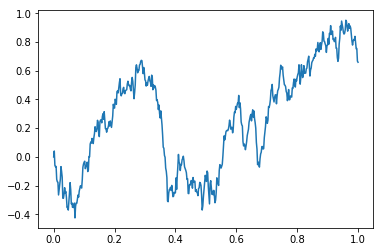

In [11]:
reset_seed()
T = 1
N = 500
dt = T/N
dW = np.sqrt(dt)*randn(N)
dW = np.insert(dW, 0, 0)
W = np.cumsum(dW)
t = np.arange(0, T+dt, dt)
plt.plot(t, W)

# bpath3.m

Using Matlab Random Numbers


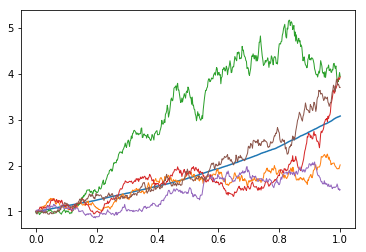

In [12]:
reset_seed()
T = 1
N = 500
M = 1000
dt = T/N
t = np.arange(0, T+dt, dt)
dW_0 = np.zeros((M, 1))
dW = np.hstack([dW_0, np.sqrt(dt)*randn(M, N)])
W = np.cumsum(dW, axis=1)
U = np.exp(np.tile(t, (M, 1)) + 0.5*W)
Umean = np.mean(U, axis=0)
plt.plot(t, Umean)
plt.plot(np.tile(t, (5, 1)).T, U[:5,].T, linewidth=1)

In [28]:
t + W

array([[ 0.00000000e+00,  4.26304368e-02,  1.31675660e-03, ...,
         3.19045060e-01,  3.60267012e-01,  4.03112292e-01],
       [ 0.00000000e+00, -9.73141003e-02, -7.22691442e-02, ...,
         1.74094349e+00,  1.79062720e+00,  1.74298572e+00],
       [ 0.00000000e+00, -8.69091832e-03,  2.17869735e-02, ...,
         1.73014524e+00,  1.71535789e+00,  1.73967871e+00],
       ...,
       [ 0.00000000e+00, -1.16654879e-02, -5.14169393e-02, ...,
         1.44382485e+00,  1.46917528e+00,  1.40924845e+00],
       [ 0.00000000e+00, -2.62365780e-02, -3.80549259e-02, ...,
         2.20115375e-01,  2.89896239e-01,  2.64422049e-01],
       [ 0.00000000e+00,  4.68652944e-02,  4.06303621e-02, ...,
        -1.16979237e-01, -1.30634862e-01, -1.02348525e-01]])

In [24]:
x = np.arange(4)
xx = x.reshape(4,1)

In [25]:
x

array([0, 1, 2, 3])

In [26]:
xx

array([[0],
       [1],
       [2],
       [3]])

# stint.m

In [41]:
reset_seed()

T = 1
N = 5000
dt = T/N
dW = np.sqrt(dt)*randn(N)
dW = np.insert(dW, 0, 0)
W = np.cumsum(dW)

ito = np.sum(W[:-1]*dW[1:])
itoerr = np.abs(ito - 0.5*(W[-1]**2 - T))

strat = np.sum((0.5*(W[:-1]+W[1:]) + 0.5*np.sqrt(dt)*randn(N)) * dW[1:])
straterr = np.abs(strat - 0.5*W[-1]**2)
ito, itoerr, strat, straterr

Using Matlab Random Numbers


(-0.16935931765031292,
 0.009205042202025115,
 0.3325843215583539,
 0.011148681410691919)

# Histogram of Error

Using Matlab Random Numbers


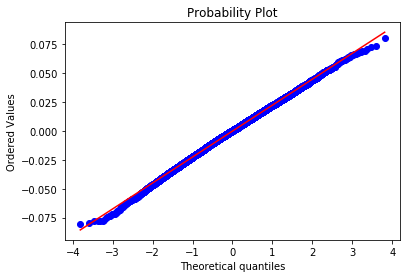

In [42]:
reset_seed()
err = np.zeros(10000)
for i in range(10000):
    T = 1
    N = 1000
    dt = T/N
    dW = np.sqrt(dt)*randn(N)
    dW = np.insert(dW, 0, 0)
    W = np.cumsum(dW)

    ito = np.sum(W[:-1]*dW[1:])
    itoerr = (ito - 0.5*(W[-1]**2 - T))
    err[i] = itoerr
#plt.hist(err, bins=30)
np.std(err)
stats.probplot(err, dist="norm", plot=pylab)
pylab.show()

# em.m

Using Matlab Random Numbers


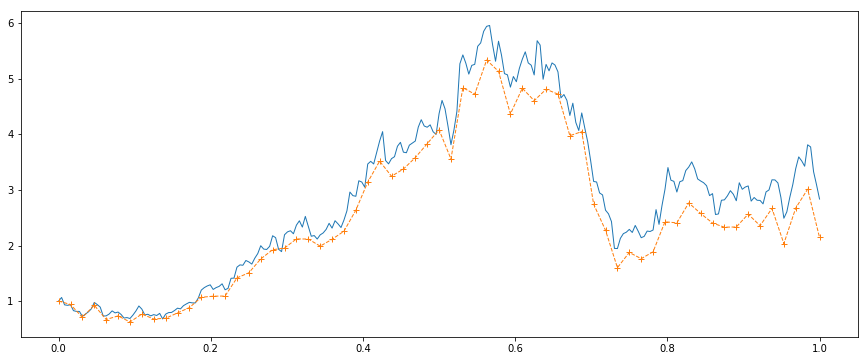

In [13]:
reset_seed()
plt.figure(figsize=(15,6))
lamda = 2
mu = 1
X_0 = 1
T = 1
N = 2**8
dt = T/N
dW = np.sqrt(dt)*randn(N)
dW = np.insert(dW, 0, 0)
W = np.cumsum(dW)
t = np.arange(0, T+dt, dt)

X_true = X_0 * np.exp((lamda-0.5*mu**2)*t + mu*W)
plt.plot(t, X_true, linewidth=1)

R = 4
Dt = R*dt
L = int(N/R)
X_em = np.zeros(L+1)
X_temp = X_0
X_em[0] = X_0
for j in range(1, L+1):
    Winc = np.sum(dW[R*(j-1)+1:R*j+1])
    X_temp = X_temp + Dt*lamda*X_temp + mu*X_temp*Winc
    X_em[j] = X_temp
plt.plot(np.arange(0, T+Dt, Dt), X_em, "+--", linewidth=1)

(array([  4.,   0.,   1.,   3.,   4.,   3.,   3.,   3.,   4.,   5.,   8.,
         19.,  39.,  55., 213., 461., 114.,  39.,  10.,   4.,   1.,   2.,
          1.,   0.,   2.,   1.,   0.,   0.,   0.,   1.]),
 array([-3.29917862, -3.0833653 , -2.86755199, -2.65173868, -2.43592537,
        -2.22011206, -2.00429875, -1.78848544, -1.57267213, -1.35685882,
        -1.1410455 , -0.92523219, -0.70941888, -0.49360557, -0.27779226,
        -0.06197895,  0.15383436,  0.36964767,  0.58546098,  0.80127429,
         1.01708761,  1.23290092,  1.44871423,  1.66452754,  1.88034085,
         2.09615416,  2.31196747,  2.52778078,  2.74359409,  2.9594074 ,
         3.17522072]),
 <a list of 30 Patch objects>)

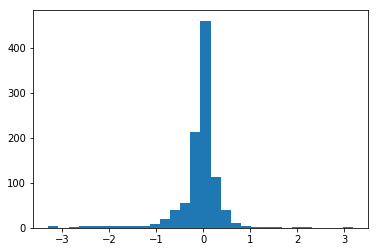

In [14]:
err = np.zeros(1000)
for i in range(1000):
    #reset_seed()
    #plt.figure(figsize=(15,6))
    lamda = 2
    mu = 1
    X_0 = 1
    T = 1
    N = 2**10
    dt = T/N
    dW = np.sqrt(dt)*randn(N)
    dW = np.insert(dW, 0, 0)
    W = np.cumsum(dW)
    t = np.arange(0, T+dt, dt)

    X_true = X_0 * np.exp((lamda-0.5*mu**2)*t + mu*W)
    #plt.plot(t, X_true, linewidth=1)

    R = 4
    Dt = R*dt
    L = int(N/R)
    X_em = np.zeros(L+1)
    X_temp = X_0
    X_em[0] = X_0
    for j in range(1, L+1):
        Winc = np.sum(dW[R*(j-1)+1:R*j+1])
        X_temp = X_temp + Dt*lamda*X_temp + mu*X_temp*Winc
        X_em[j] = X_temp
    endpoint_err = X_em[-1] - X_true[-1]
    err[i] = endpoint_err
plt.hist(err, 30)

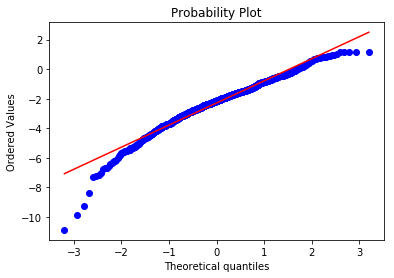

In [15]:
stats.probplot(np.log(np.abs(err)), dist="norm", plot=pylab)
pylab.show()

In [8]:
X_true[-1] - X_em[-1]

0.6907476291643118

Using numpy Random Numbers


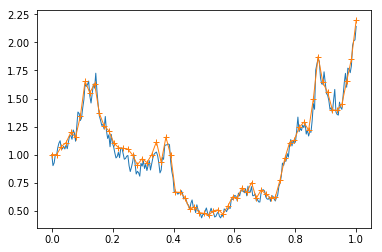

In [48]:
reset_seed()
lamda = 2
X_0 = 1
mu = 1
f = lambda x: lamda * x
g = lambda x: mu * x

t, W = brownian_path(1, 2**8)
X_true = X_0 * np.exp((lamda-0.5*mu**2)*t + mu*W)
t_em, X_em = solve_em(f, g, X_0, t[::4], W[::4])

plt.plot(t, X_true, linewidth=1)
plt.plot(t_em, X_em, "+-", linewidth=1)

(array([7.000e+00, 2.400e+01, 3.550e+02, 7.539e+03, 1.567e+03, 2.950e+02,
        9.600e+01, 4.800e+01, 1.500e+01, 1.700e+01, 6.000e+00, 6.000e+00,
        6.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-4.92481421, -3.58963672, -2.25445923, -0.91928174,  0.41589575,
         1.75107324,  3.08625073,  4.42142822,  5.75660571,  7.09178321,
         8.4269607 ,  9.76213819, 11.09731568, 12.43249317, 13.76767066,
        15.10284815, 16.43802564, 17.77320313, 19.10838062, 20.44355811,
        21.7787356 , 23.11391309, 24.44909058, 25.78426808, 27.11944557,
        28.45462306, 29.78980055, 31.12497804, 32.46015553, 33.79533302,
        35.13051051]),
 <a list of 30 Patch objects>)

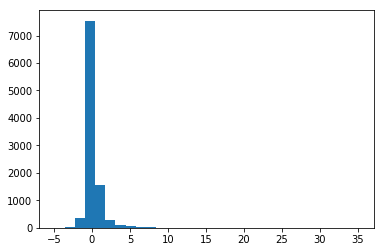

In [53]:
n_simulations = 10000
err = np.zeros(n_simulations)
for i in range(n_simulations):
    lamda = 2
    X_0 = 1
    mu = 1
    f = lambda x: lamda * x
    g = lambda x: mu * x

    t, W = brownian_path(1, 2**8)
    X_true = X_0 * np.exp((lamda-0.5*mu**2)*t + mu*W)
    t_em, X_em = solve_em(f, g, X_0, t[::4], W[::4])
    final_time_error = X_true[-1] - X_em[-1]
    err[i] = final_time_error
plt.hist(err, bins=30)


In [54]:
np.max(err)

35.1305105108803

# emstrong.m

Using Matlab Random Numbers


(0.001, 0.1)

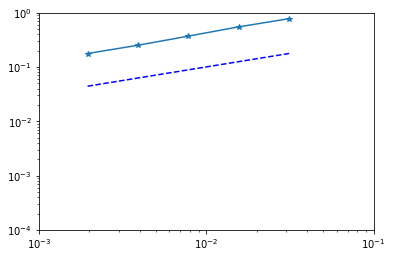

In [13]:
reset_seed()

lamda = 2
X_0 = 1
mu = 1
f = lambda x: lamda * x
g = lambda x: mu * x

dt = 2**(-9)
T = 1
M = 1000
N = int(T/dt)

X_err = np.zeros((M, 5))

#t = np.arange(0, T+dt, dt)
#dW_0 = np.zeros((M, 1))
#dW = np.hstack([dW_0, np.sqrt(dt)*randn(M, N)])
#Ws = np.cumsum(dW, axis=1)

for path in range(M):
    t, W = brownian_path(T=T, N=int(T/dt))
    #W = Ws[path]
    X_true = X_0 * np.exp((lamda-0.5*mu**2)*t + mu*W)
    for p in range(5):
        t_em, X_em = solve_em(f, g, X_0, t[::2**p], W[::2**p])
        endpoint_error = np.abs(X_em[-1] - X_true[-1])
        X_err[path, p] = endpoint_error
        
dt_vals = 2**np.arange(5) * 2**(-9)

plt.loglog(dt_vals, np.mean(X_err, axis=0), "*-")
plt.loglog(dt_vals, dt_vals**0.5, "b--")

plt.ylim(10**(-4), 1)
plt.xlim(10**(-3), 10**(-1))        

In [14]:
stats.linregress(np.log(dt_vals),np.log(np.mean(X_err, axis=0)))

LinregressResult(slope=0.5383664717975093, intercept=1.6161069241740602, rvalue=0.999745266563053, pvalue=4.880296354941735e-06, stderr=0.007017110857738456)

# milstrong

Using Matlab Random Numbers


(0.001, 0.1)

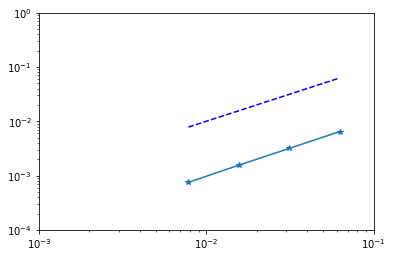

In [15]:
reset_seed()

r = 2
K = 1
beta = 0.25
X_0 = 0.5

f = lambda x: r*x*(K-x)
g = lambda x: beta*x
g_deriv = lambda x: beta

dt = 2**(-11)
T = 1
M = 500
N = int(T/dt)

X_err = np.zeros((M, 4))

t = np.arange(0, T+dt, dt)
dW_0 = np.zeros((M, 1))
dW = np.hstack([dW_0, np.sqrt(dt)*randn(M, N)])
Ws = np.cumsum(dW, axis=1)

for path in range(M):
    #t, W = brownian_path(T=T, N=int(T/dt))
    W = Ws[path]
    X_true = solve_milstein(f, g, g_deriv, X_0, t, W)[1]
    for i, p in enumerate(range(4, 8)):
        t_em, X_em = solve_milstein(f, g, g_deriv, X_0, t[::2**p], W[::2**p])
        endpoint_error = np.abs(X_em[-1] - X_true[-1])
        X_err[path, i] = endpoint_error
        
dt_vals = 2**np.arange(4,8) * dt

plt.loglog(dt_vals, np.mean(X_err, axis=0), "*-")
plt.loglog(dt_vals, dt_vals, "b--")

plt.ylim(10**(-4), 1)
plt.xlim(10**(-3), 10**(-1))      

In [16]:
import scipy.stats as stats
stats.linregress(np.log(dt_vals),np.log(np.mean(X_err, axis=0)))

LinregressResult(slope=1.0315778833566316, intercept=-2.1819670135074842, rvalue=0.9999822137952978, pvalue=1.7786204702163754e-05, stderr=0.004350603040377452)

---------------------

# milstein2

Using Matlab Random Numbers


(0.001, 0.1)

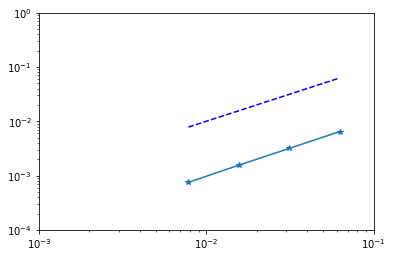

In [27]:
reset_seed()

r = 2
K = 1
beta = 0.25
X_0 = 0.5

f = lambda x: r*x*(K-x)
g = lambda x: beta*x
g_deriv = lambda x: beta

dt = 2**(-11)
T = 1
M = 500
N = int(T/dt)

X_err = np.zeros((M, 4))

t, W = brownian_path2(T=T, N=int(T/dt), M=M)

X_true = solve_milstein2(f, g, g_deriv, X_0, t, W)[1]

for i, p in enumerate(range(4, 8)):
    t_em, X_em = solve_milstein2(f, g, g_deriv, X_0, t[::2**p], W[:,::2**p])
    X_err[:, i] = np.abs(X_em[:,-1] - X_true[:,-1])
        
dt_vals = 2**np.arange(4,8) * dt

plt.loglog(dt_vals, np.mean(X_err, axis=0), "*-")
plt.loglog(dt_vals, dt_vals, "b--")

plt.ylim(10**(-4), 1)
plt.xlim(10**(-3), 10**(-1))      

In [28]:
stats.linregress(np.log(dt_vals),np.log(np.mean(X_err, axis=0)))

LinregressResult(slope=1.0315778833566316, intercept=-2.1819670135074842, rvalue=0.9999822137952978, pvalue=1.7786204702163754e-05, stderr=0.004350603040377452)

# emweak

Using numpy Random Numbers


(0.001, 0.1)

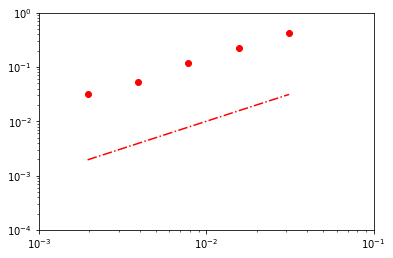

In [56]:
reset_seed()

lamda = 2
mu = 0.1

f = lambda x: lamda * x
g = lambda x: mu * x

X_0 = 1
T = 1
M = 50000
X_em = np.zeros(5)
for i, p in enumerate(range(1, 6)):
    Dt = 2**(p-10)
    L = int(T/Dt)
    t, W = brownian_path2(T, L, M)
    X_em[i] = solve_em2(f, g, X_0, t, W)[1][:,-1].mean()
X_err = np.abs(X_em - np.exp(lamda*T))

dt_vals = 2**(np.arange(1, 6).astype(float)-10)
plt.loglog(dt_vals, X_err, "ro")
plt.loglog(dt_vals, dt_vals, "r-.")

plt.ylim(10**(-4), 1)
plt.xlim(10**(-3), 10**(-1))      

# Implicit Method

Using numpy Random Numbers


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


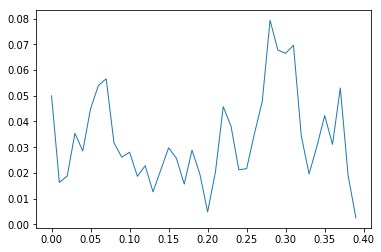

In [17]:
reset_seed()
T = 1
N = 100
dt = T/N
dW = np.sqrt(dt)*randn(N)
dW = np.insert(dW, 0, 0)
W = np.cumsum(dW)

k = 1
lamda = 0.05
theta = 1#2*k*lamda * 0.01
#assert 2*k*lamda > theta**2
alpha = (4*k*lamda - theta**2)/8
beta = -k/2
gamma = theta/2

Y_implicit = np.zeros(N+1)


X_0 = lamda
Y_temp = np.sqrt(X_0)
Y_implicit[0] = np.sqrt(X_0)
for k in range(1, N+1):
    W_inc = dW[k]
    Y_temp = (Y_temp + gamma*dW[k])/(2*(1-beta*dt)) \
             + np.sqrt(
                 (Y_temp + gamma*dW[k])**2/(4*(1-beta*dt)**2) \
                 + (alpha*dt)/(1-beta*dt)
             )
    Y_implicit[k] = Y_temp
X_implicit = Y_implicit**2
plt.plot(np.arange(0, T+dt, dt), X_implicit, linewidth=1)

Using numpy Random Numbers


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


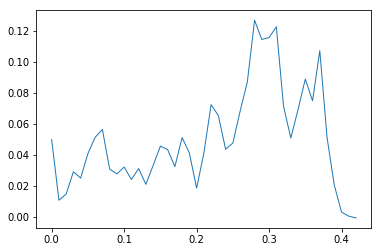

In [15]:
reset_seed()
t, W = brownian_path(1, 100)
k = 1
lamda = 0.05
theta = 1

f = lambda x: k * (lamda - x)
g = lambda x: theta * np.sqrt(x)

em = solve_em(f, g, lamda, t, W)[1]
plt.plot(t, em, linewidth=1)

- General direction of project: goals etc
- Functions, vs self contained scripts
- EM vs implicit method
- $W(\tau_j) - W(\tau_{j-1})$
- Order of convergence definition in both papers
- 